<a href="https://colab.research.google.com/github/LucasMelvin15/machine_learning-projects/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project
 **Dog Vision**  - Using computer vision to classify dog photos into different breeds.

 **Data**: Images of dogs from Stanford Dogs Dataset (120 dog breeds, 20,000+ images).

 **Problem type**: Multi-class classification (120 different classes).

**Goals**: Use TensorFlow, deep learning and transfer learning, beat the original research paper results (22% accuracy).

## Data description
- `train.zip` - the training set, you are provided the breed for these dogs
- `test.zip` - the test set, you must predict the probability of each breed for each image
- `sample_submission.csv` - a sample submission file in the correct format
- `labels.csv` - the breeds for the images in the train set

In [1]:
#!unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog Vision/"


In [2]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

TF version: 2.17.0
TF Hub version: 0.16.1


## Getting our data ready (Turning it into tensors)

1. Accessing data and checking out the labels

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


In [4]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

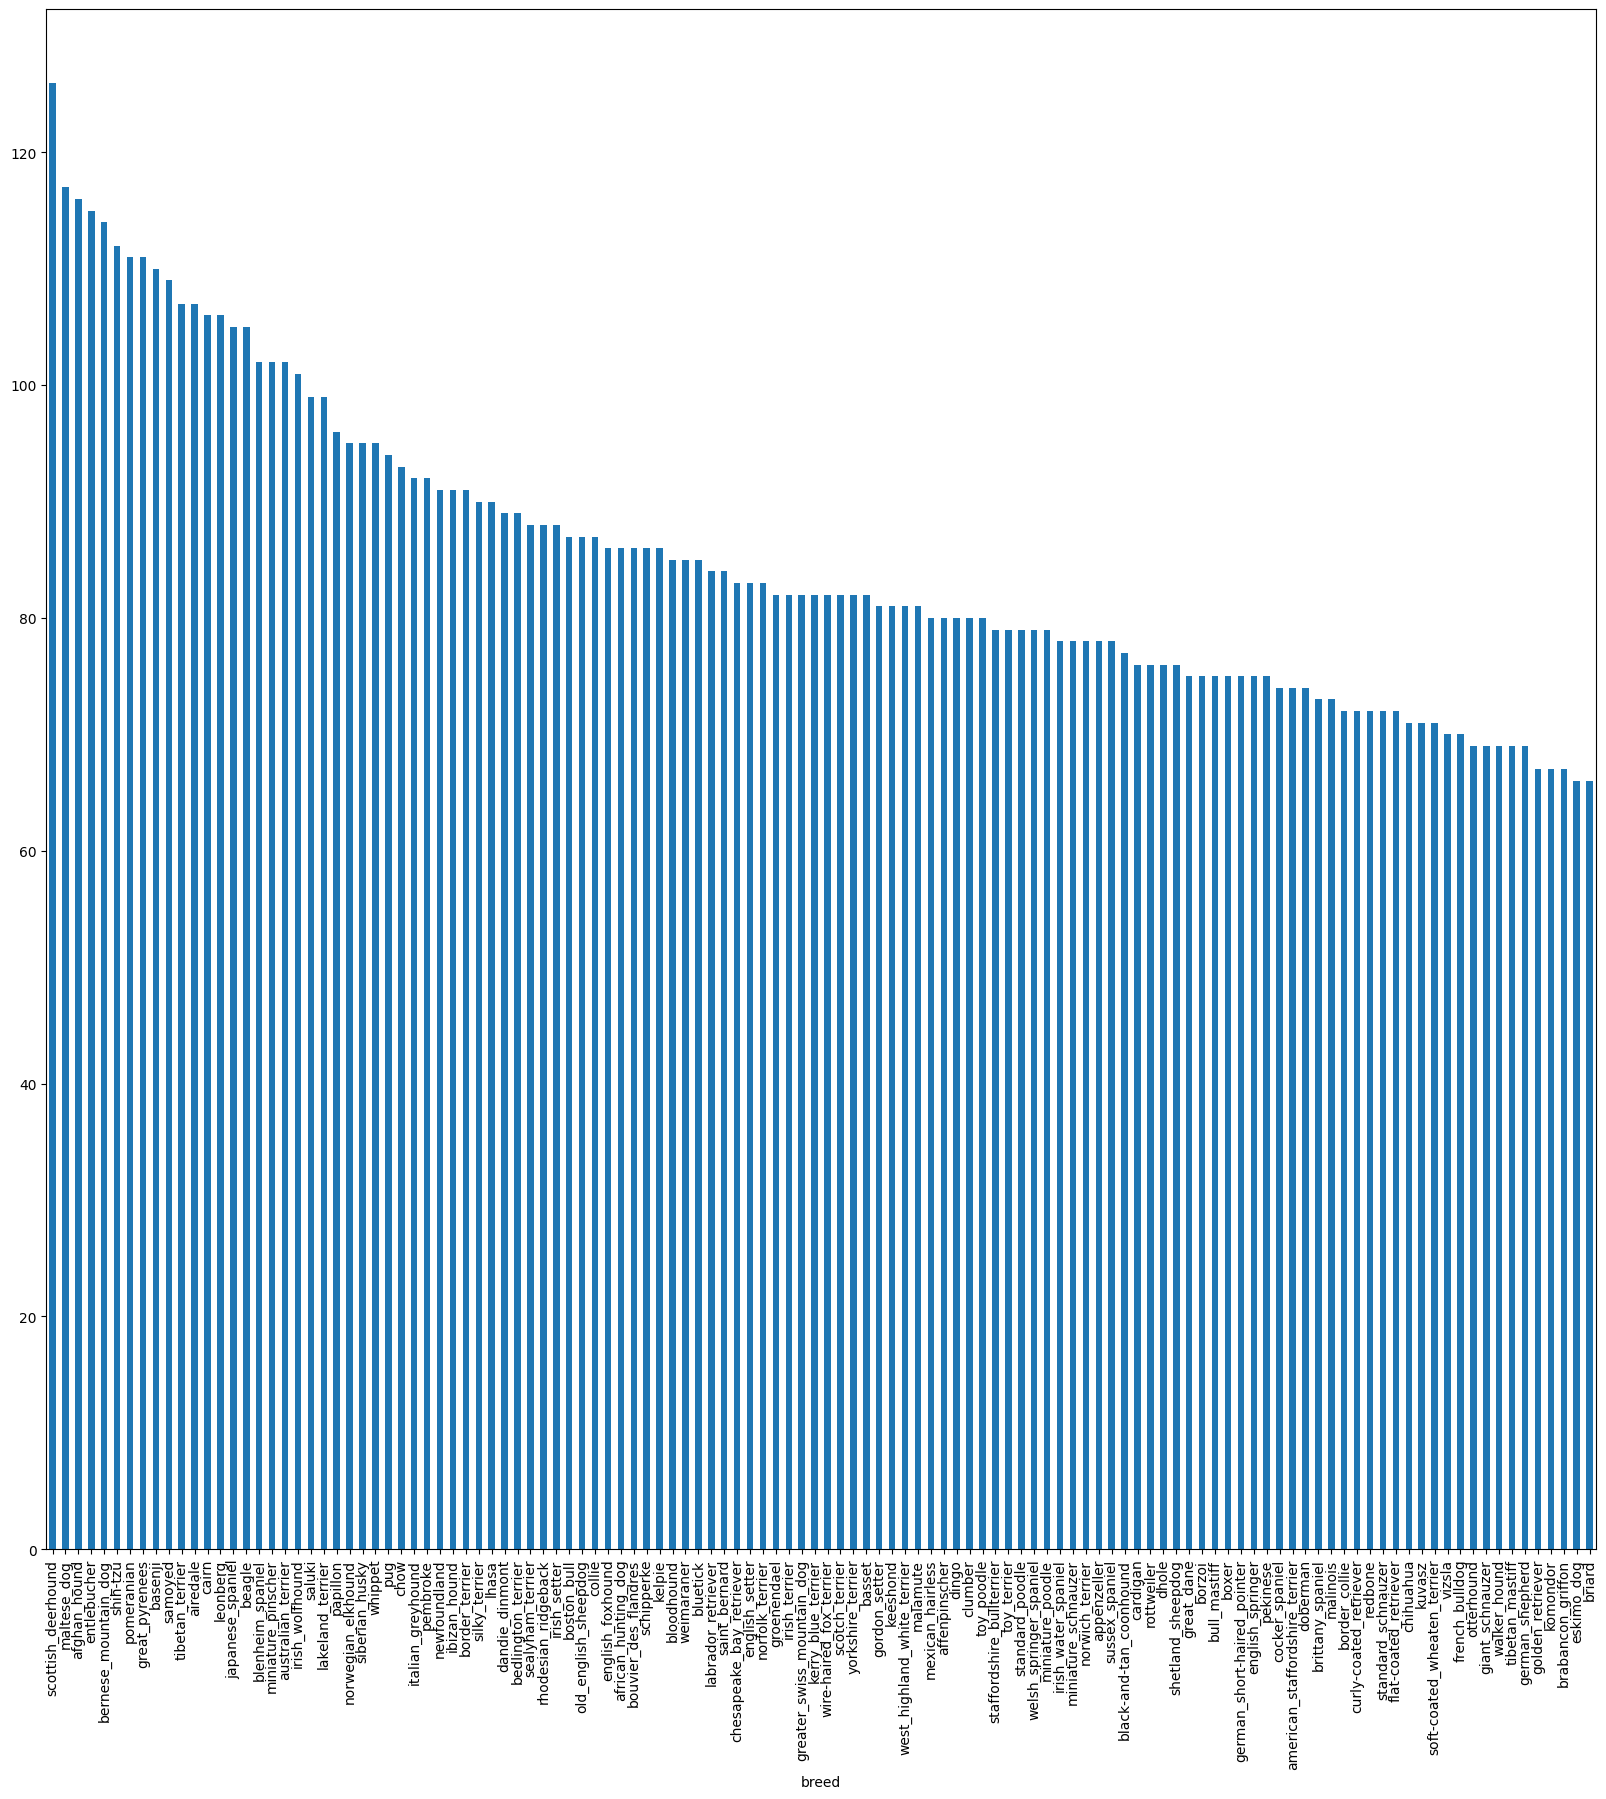

In [5]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,20))

In [6]:
labels_csv["breed"].value_counts().median() #about 82 per breed

82.0

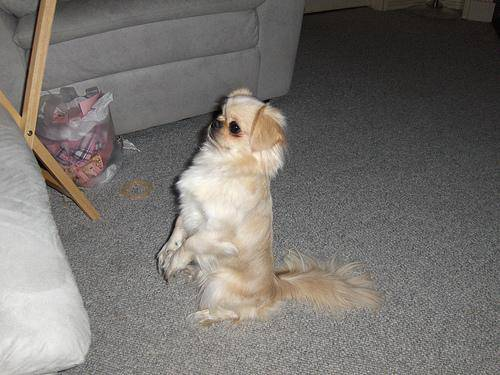

In [7]:
# View an image
from IPython.display import Image
Image("/content/drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg")

### Getting images and their labels
- Get a list of all image file pathnames

In [8]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [9]:
# Create pathnames from image ids
filenames = [ "drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]


['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether the number of filenames matches the number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames matches the the amout of actual files")
else:
  print("Filenames do not match. Check target directory")

Filenames matches the the amout of actual files


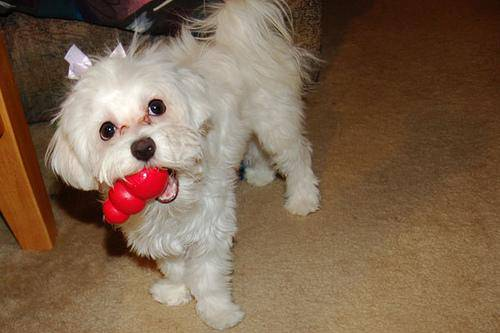

In [11]:
Image(filenames[700])

In [12]:
labels_csv["breed"][700]

'maltese_dog'

Since we've now got our training image filepaths in a list, let's prepare our labels and convert the into a numpy array

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels =  np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# Compare the number of labels matches number of  filenames ie checking for missing data
if len(labels) == len(filenames):
  print("Number of labels match the number of filenames")
else:
  print("Number of labels does not match number of filenames")


Number of labels match the number of filenames


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# Turn every label into a boolean array
# Create a boolean array for each label in the labels array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [19]:
len(boolean_labels)

10222

In [20]:
# Turn boolean array into labels
print(labels[0]) #original labels
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in a boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample accurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
The current dataset only has training and test sets

In [21]:
# Set up X and y
X = filenames
y = boolean_labels

In [22]:
len(filenames)

10222

Start off experimenting with 1000 images and increase as needed

In [23]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [24]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

# split into training and validation of total size  NUM_IMAGES
X_train, X_val , y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size=0.2,
                                                   random_state=42)
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [25]:
X_train[:5]

['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
 'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
 'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
 'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
 'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg']

In [26]:
y_train[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## Preprocessing images - turning images into Tensors



In [27]:
# Importing an image
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [28]:
image.max(), image.min() # color channels range from 0 to 255

(255, 0)

In [29]:
# Turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Create a function that
1. Takes an image filepath as input
2. Use TensorFlow to read the file and save it to variable , `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our image - convert color channels from 0-255 to 0-1
5. Resize the image to be a shape of (224, 224)
6. Return the modified image

In [30]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image and turns it into a tensor
  """
  # Load the image from the file path
  image = tf.io.read_file(image_path)

  # Decode the image to a tensor (for jpg images)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to (224, 224)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  return image



## Turning our data into batches(32)

In [31]:
# Create a simple function to return a tuple
def get_image_label (image_path, label):
  """Takes an image file path name and associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image , label

In [32]:
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [33]:
# Define a batch size
BATCH_SIZE = 32

# Create a function to turn our data into batches
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs
  Shuffles the data if its training data but doesn't shuffle if its validation data
  Also accepts test data as input (no labels )
  """

  # if test data we only need images without labels
  if test_data:
    print("Creating test batches ")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # tf dataset made of  X (images)
    data_batch = data.map(process_image).batch(BATCH_SIZE) # Only process images
    return data_batch

  # if  validation data, no need to shuffle
  elif valid_data:
    print("Creating validation batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))  # X, y pairs
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  # If training data, shuffle the data
  else:
    print("Creating training data batches")
    # turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))  # X, y pairs

    # Shuffle the pathnames and labels
    data = data.shuffle(buffer_size=len(X))

    # create (image, label) tuples and create a batch
    data_batch = data.map(get_image_label).batch(batch_size)

    return data_batch


In [34]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val , valid_data=True)


Creating training data batches
Creating validation batches


In [35]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

In [36]:
import matplotlib.pyplot as plt

# create a function for viewing images in a batch
def show_25_images(images, labels):
  #set up figure
  plt.figure(figsize=(15,15))
  # Loop thru 25 for displaying images
  for i in range(25):
    #create a subplot(5rows, 5cols)
    ax = plt.subplot(5, 5 , i+1)
    # Display an image
    plt.imshow(images[i])
    # add the label as the tutle
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn off the axis for better display
    plt.axis('off')


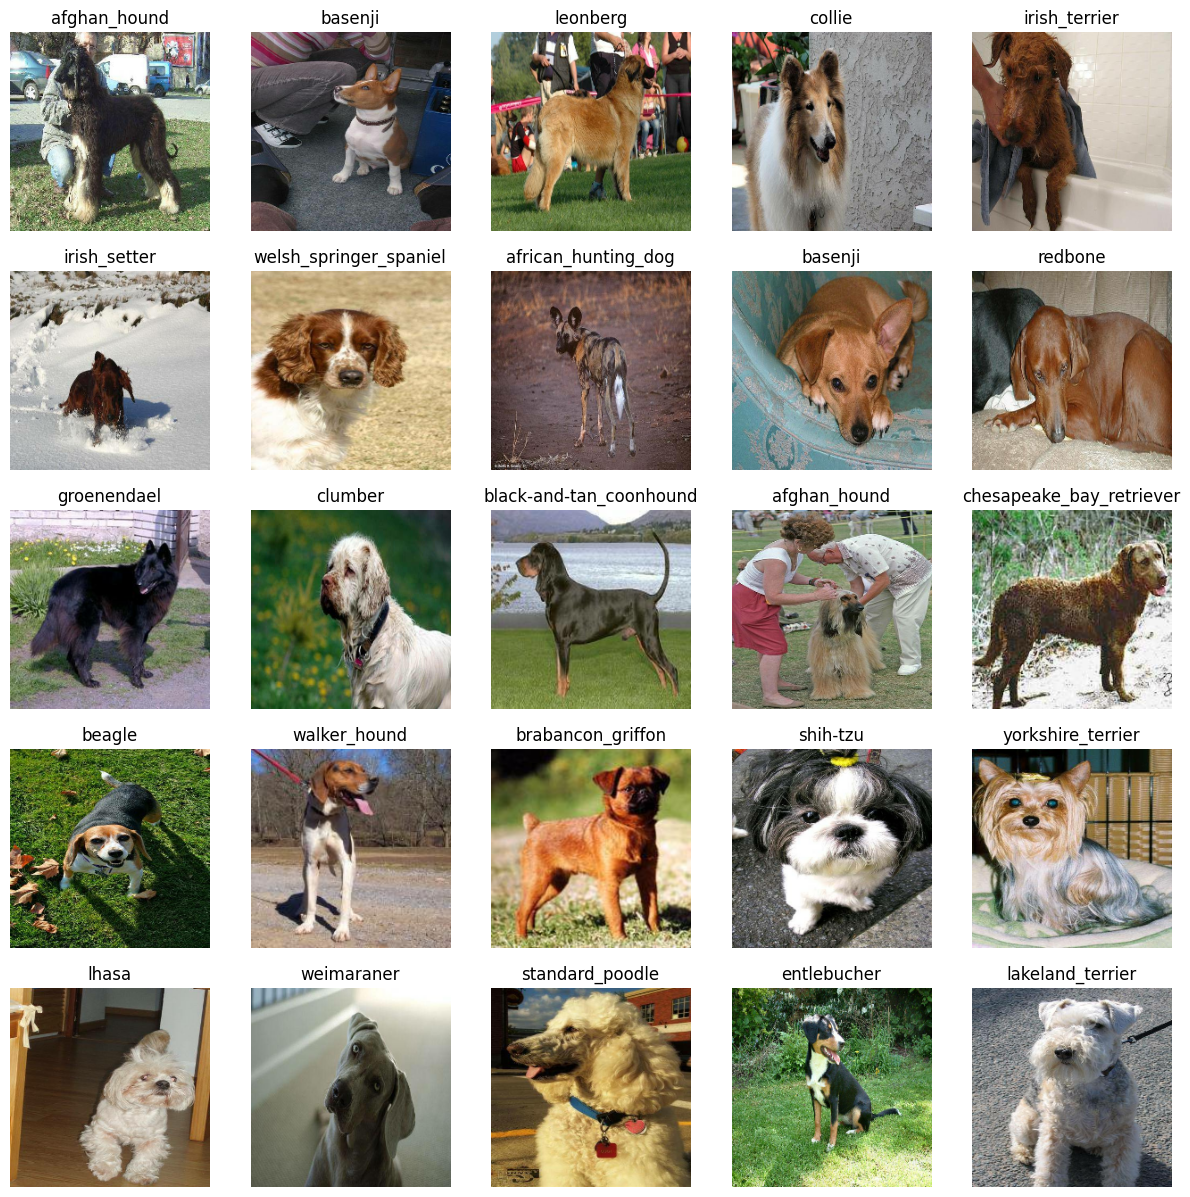

In [37]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)
show_25_images(train_images,train_labels )

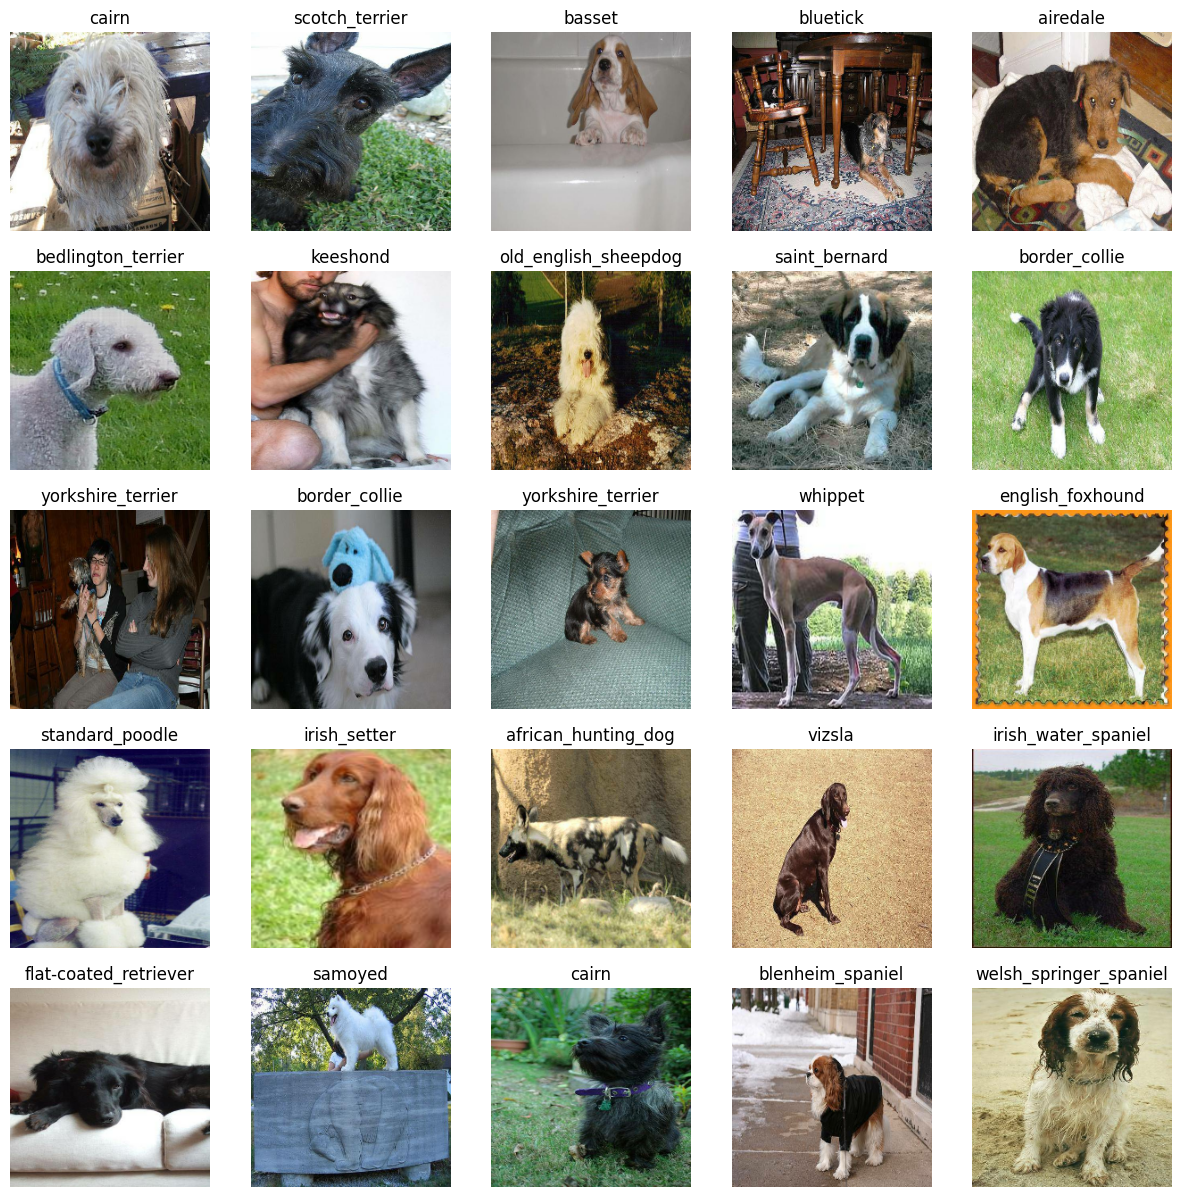

In [38]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
len(val_images), len(val_labels)
show_25_images(val_images,val_labels )

## Preparing inputs and outputs and model selection
* The input shape( our images shape, in the form of tensors)
* The output shape( image labels, in the form of tensors)

In [39]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

## Building a deep learning model
Create a function that:
1. Takes an input shape, output shape, model url
2. Defines the layers in a keras model in a sequential fashion
3. Compiles the model(says how it should be evaluated and improved)
4. Builds the model
5. Returns the model

In [40]:
!pip install tf_keras
import tf_keras as keras

In [41]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", model_url)

    # Set up the model layers
    model = keras.Sequential([
        hub.KerasLayer(model_url),
        keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation="softmax")
    ])

    # Compile the model
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Build the model (assuming input_shape includes batch size as None, e.g., (None, 224, 224, 3))
    model.build(INPUT_SHAPE)

    return model


In [42]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


Monitoring experiments using tensorboard

In [43]:
# Load tensorboard for callbacks
%load_ext tensorboard

In [44]:
import datetime

#Create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing tensorboard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return keras.callbacks.TensorBoard(logdir)

In [45]:
# Create an early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=3)

## Model Training

In [46]:
NUM_EPOCHS = 100

In [47]:
# build a function for train model
def train_model():
    # create a model
    model = create_model()

    # create a new tensorboard
    tensorboard = create_tensorboard_callback()

    # fit the model to the data
    model.fit(x=train_data,
          epochs=NUM_EPOCHS,
          validation_data=val_data,
          validation_freq=1,
          callbacks=[tensorboard, early_stopping]
         )

    return model

In [48]:
#fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 366s 15s/step - loss: 4.6652 - accuracy: 0.0988 - val_loss: 3.6978 - val_accuracy: 0.2050
Epoch 2/100
25/25 [==============================] - 4s 137ms/step - loss: 1.7154 - accuracy: 0.6737 - val_loss: 2.2775 - val_accuracy: 0.4600
Epoch 3/100
25/25 [==============================] - 4s 162ms/step - loss: 0.5961 - accuracy: 0.9275 - val_loss: 1.7453 - val_accuracy: 0.5650
Epoch 4/100
25/25 [==============================] - 5s 213ms/step - loss: 0.2655 - accuracy: 0.9837 - val_loss: 1.5585 - val_accuracy: 0.5850
Epoch 5/100
25/25 [==============================] - 4s 160ms/step - loss: 0.1511 - accuracy: 0.9962 - val_loss: 1.4719 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 4s 161ms/step - loss: 0.1028 - accuracy: 1.0000 - val_loss: 1.4167 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================

In [49]:
# Check the tensorboard logs
#Uncommoment to render
# %tensorboard --logdir /content/drive/MyDrive/Dog\ Vision/logs

## Making and evaluating predictions with a trained model

In [50]:
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 2s 128ms/step


array([[1.6385247e-03, 9.9103854e-05, 7.9255039e-04, ..., 3.1851052e-04,
        3.0377430e-05, 1.8343984e-03],
       [2.1254106e-03, 3.0660586e-04, 1.4757164e-03, ..., 4.7918039e-04,
        7.3454075e-04, 7.0094015e-04],
       [8.0546506e-06, 1.4114121e-04, 1.1672784e-04, ..., 4.2821343e-05,
        1.0206805e-05, 2.1559448e-04],
       ...,
       [1.7827064e-06, 2.8010265e-05, 2.0002740e-04, ..., 1.0115239e-05,
        9.9574381e-06, 3.2724871e-05],
       [5.4186904e-03, 6.1583662e-05, 3.1878482e-04, ..., 1.2574260e-04,
        7.0131486e-05, 7.5710053e-03],
       [8.6883665e-04, 8.9718824e-06, 2.8875575e-03, ..., 3.1736307e-03,
        2.6334208e-03, 7.3629904e-05]], dtype=float32)

In [51]:
predictions.shape # number of val images and labels

# Prediction give an array adding upto 1
#np.sum(predictions[0])

(200, 120)

In [52]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value (probability of prediction):{np.max(predictions[index])}")
print(f"sum: {np.sum(predictions[index])}")
print(f" Max index:{np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.63852470e-03 9.91038542e-05 7.92550389e-04 4.96884786e-05
 9.34655254e-05 2.71819463e-05 9.45758913e-03 4.25594160e-04
 9.67438245e-05 6.28868293e-04 8.43563699e-04 9.75915464e-05
 1.60541589e-04 5.78970867e-05 1.17151963e-03 3.52081057e-04
 8.74411708e-05 1.31876513e-01 1.64899539e-05 4.05759056e-05
 3.16957274e-04 1.02224498e-04 8.20407440e-05 4.55430796e-04
 3.33385615e-05 2.87710631e-04 1.30370244e-01 9.59090758e-05
 1.62806141e-03 1.70784842e-04 1.91205472e-04 1.34739082e-03
 1.03269027e-04 3.06682682e-06 6.26228393e-06 1.77629903e-01
 3.62501123e-05 4.05429688e-04 2.33764349e-05 5.38938075e-05
 7.82331103e-04 4.28419880e-05 9.03328182e-05 4.91044302e-05
 1.67052531e-05 4.80281567e-04 1.12668458e-04 2.12145227e-04
 1.59785064e-04 6.94195405e-05 1.09443790e-04 1.47535029e-05
 1.28989632e-03 1.58515890e-04 8.23462033e-05 8.64500998e-06
 1.26154351e-04 1.52841648e-02 4.89774568e-04 3.68949994e-02
 1.36793984e-04 8.38678679e-05 2.84363306e-03 4.17737538e-05
 3.98651289e-04 1.057719

In [53]:
unique_breeds[26]

'cairn'

In [54]:
# Turn prediction probabilities into thier pred label
def get_pred_label(prediction_probabilities):
  #turns an array of pred probabilities into a label
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [58]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

#### View predictions
The first function we'll create will:

- Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
- Convert the prediction probabilities to a predicted label.
- Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [59]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

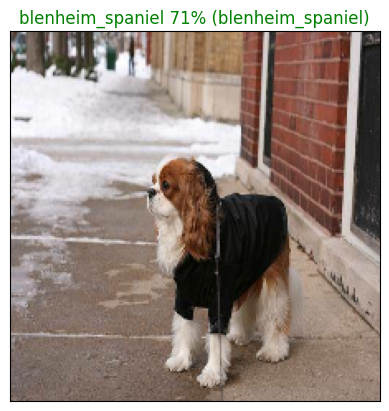

In [63]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=23)

## Training the model on the full dataset

In [64]:
len(X), len(y)

(10222, 10222)

In [65]:
full_data = create_data_batches(X,y)

Creating training data batches


In [66]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [67]:
# Create a model for the full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [70]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 47s 131ms/step - loss: 1.3511 - accuracy: 0.6628
Epoch 2/100
320/320 [==============================] - 41s 128ms/step - loss: 0.4090 - accuracy: 0.8761
Epoch 3/100
320/320 [==============================] - 42s 132ms/step - loss: 0.2461 - accuracy: 0.9307
Epoch 4/100
320/320 [==============================] - 42s 131ms/step - loss: 0.1575 - accuracy: 0.9612
Epoch 5/100
320/320 [==============================] - 41s 127ms/step - loss: 0.1064 - accuracy: 0.9779
Epoch 6/100
320/320 [==============================] - 40s 125ms/step - loss: 0.0781 - accuracy: 0.9866
Epoch 7/100
320/320 [==============================] - 41s 127ms/step - loss: 0.0594 - accuracy: 0.9906
Epoch 8/100
320/320 [==============================] - 43s 135ms/step - loss: 0.0452 - accuracy: 0.9957
Epoch 9/100
320/320 [==============================] - 41s 129ms/step - loss: 0.0374 - accuracy: 0.9967
Epoch 10/100
320/320 [==============================] - 42s 133m